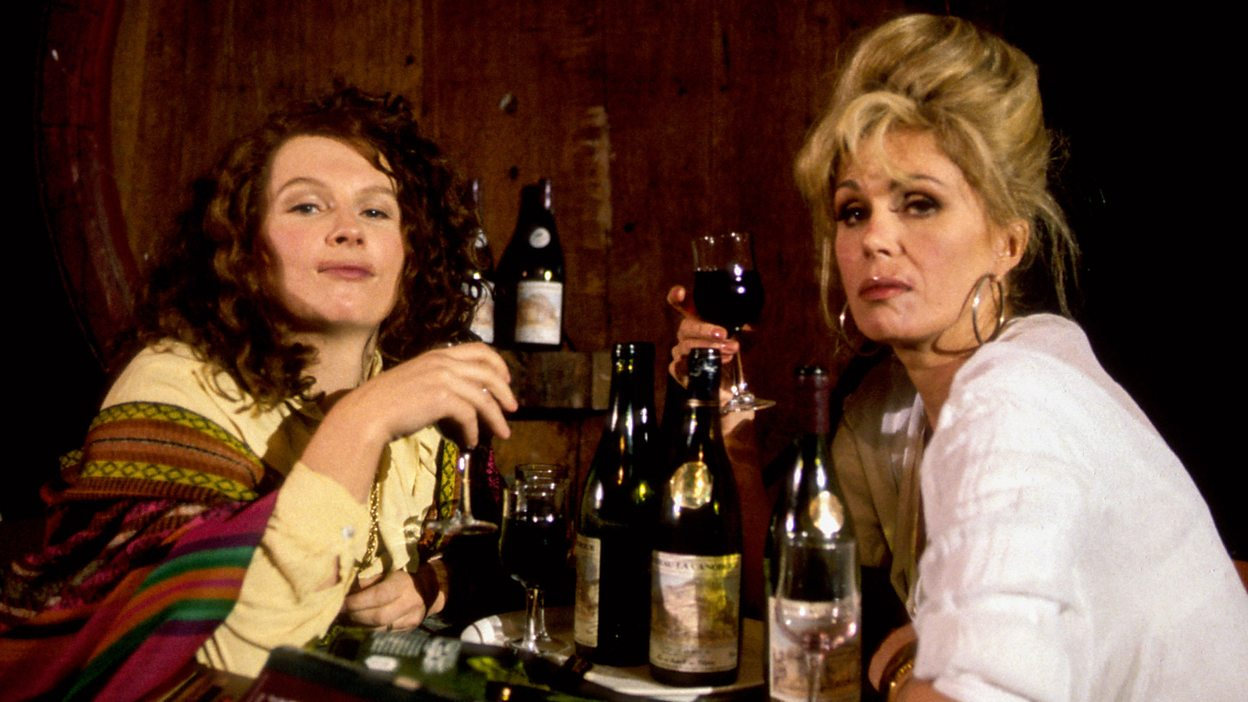

## 1. Introduction

### 1.1 Aim

In this project, we will explore the 'Wine Quality' datasets and seek to implement a regression model to accurately predict wine pH based on a group of associated variables.

### 1.2 Background

Acidity is an intrinsic factor in wine and needs to be carefully balanced with the other fundamental traits (tannin, alcohol, and sweetness) to create high-quality wine. All wines are acidic (pH < 7), with most having a pH value ranging from 2.5 to about 4.5 pH. There are several different types of acids found in wine, the most prevalent are tartaric acid, malic acid, and citric acid. White wines tend to be slightly more acidic than reds, with a pH commonly ranging from 3.0 - 3.4 compared to the 3.3 - 3.6 pH range found in red wines.

Wine pH can be altered at numerous junctions from vineyard to bottle. Vineyard climate can influence the acidity of wines, with cooler climates producing less acidic grapes and vice versa. Certain maturation processes convert the type of acid present in a wine. For example, malolactic fermentation (MLF) is a process where tart-tasting malic acid, naturally present in grape must is converted to softer tasting lactic acid, reducing acidity.

There are cheap and simple ways of measuring pH (using tools such as pH meters or litmus paper), so there isn't a high value associated with the model in question. However, the main aim for this project was to build my first regression model, and as regression models are ineffective for predicting the common target in this dataset 'wine quality' (an ordinal target), I chose to predict the continuous variable 'pH' instead.

### 1.3 Dataset information: 'Wine Quality'

**From [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/wine+quality)**

"*The datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. For more details, consult: [Web Link](https://www.vinhoverde.pt/en/) or the reference [Cortez et al., 2009]. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc).*

*These datasets can be viewed as classification or regression tasks. The classes are ordered and not balanced (e.g. there are many more normal wines than excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to test feature selection methods.*"

## 2. Exploratory Data Analysis

### 2.1 Descriptive statistics

Before we begin feature selection or modeling, we need to assess the data structure and quality. Let's view the variables and data-types present within the dataset:

In [ ]:
#import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#open dataset in pandas
df = pd.read_csv(r"D:\DSProjects\Data_Science\Quick Projects\wine_pH\winequality-red.csv")
#view df data type and size
df.info()

We can see the dataset is comprised of 12 numerical variables: 11 continuous float and 1 discrete integer. The dataset also contains 1599 data points. Using the approximation that any given sample should have a ratio of ~10:1 for data points to variables, the sample size of 1599 is above the guideline value of 120 (12 * 10), and should be sufficiently large for modelling. Let's check the dataset for any null values:

In [ ]:
#shows whether df has any null values
if df.isna().sum().sum() > 0:
    print("null values detected")
print("no null values detected")

The dataset contains no null values, so no imputation or removal of data is required. Now let's assess the distribution of our target variable 'pH':

In [ ]:
#drop quality variable
df = df.drop(['quality'], axis = 1)

#show pH distribution
plt.figure(figsize=(15,6))
sns.histplot(df['pH'], bins=30)
plt.show()

We can see that pH ranges between 2.7 and  4. The data follows a normal distribution with asymmetrical tails, with a slightly higher abundance of wines to the left-hand side of the peak.

### 2.2 Boxplot distributions

Let's assess the distributions and outliers of our variables using seaborn's boxplot function. Before we can create boxplots, we need to scale distributions so they all fit on the same graph. I have chosen to use MinMax scaler and it doesn't normalize data and retains outliers. Let's scale our data and create the boxplot:

In [ ]:
#import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

#assign our scaling function and scale data
scaler = MinMaxScaler()

#scale value
scaled_df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns.tolist())

#plot figure
plt.figure(figsize=(15,5))
sns.boxplot(data = scaled_df)
plt.show()

`pH` and `Density` show normal distributions, with the remaining variables exhibiting right-skewed distributions, more akin to the log-normal. The strong right-skews of `residual sugar` and `chlorides` can be seen through their low scaled median values, compact interquartile ranges, and a large number of outliers sitting above the boxplot range. 

The chart also depicts 'outlier' amongst distributions. We can see that all variables have flagged outliers above the boxplot range. `chlorides`, `density`, `pH` and `quality` have outliers sitting below the boxplot range too. Given their abundance, it is unlikely that all marked outliers are genuine outliers. It is more likely that our variable distributions are non-normal and/or the cutoff for outlier detection in seaborn's boxplot function is too low for our dataset.

## 3. Feature engineering

Feature engineering is the process of transforming raw features to improve their predictive value for a given model. We will employ several engineering techniques to optimize our data: normalization, outlier removal scaling, rounding, bivariate feature inclusion, and polynomial feature inclusion.

### 3.1 Scoring function

We will assess engineered features by creating two datasets: a control set containing the independent variables, a test set containing independent variables, and the engineered features. Each dataset will be modeled using a series of classifiers and model performance will be evaluated by cross-validation using r2 and negative mean squared error (nMSE) scoring metrics. Comparing performance between models can be used to infer the strength of altered features.

A collection of regression algorithms will be used to predict data: Ordinary Least Squares (Linear), Ridge, Lasso, ElasticNet, LassorLars, Orthogonal Matching Pursuit, Bayesian Ridge, TheilSen, and Huber. I won't go into detail on how these algorithms function, but you can read an overview of how each model works on [Sklearn's website](https://scikit-learn.org/stable/modules/linear_model.html).

The r2 score (known as the coefficient of determination) is a measure of how close the data are to the fitted regression line. An r2 score of 1 implies that the model explains all the variability of the dependent variable around its mean and a score of 0 implies the inverse. The r2 score does have two major limitations: it can't determine whether the coefficient estimates and predictions are biased, and it does not indicate how accurate a regression model is. More detail on the r2 score can be found [here](https://blog.minitab.com/en/adventures-in-statistics-2/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit).

Mean squared error tells you how close a regression line is to a set of points. It measures the distances from the points to the regression line (errors) and squares the values. The mean of squared errors is returned. Lower scores are indicative of more accurate models. The negative mean squared error is proportionally identical same as the mean squared error but is converted into a negative number. I believe this is done so that model performance visualizations are easier to interpret, with high-performing models (with low nMSE scores) appearing at the top of the chart instead of the bottom. More details on mean squared error can be found [here](https://www.statisticshowto.com/mean-squared-error/).

We will employ a K-fold cross-validation strategy to assess model accuracy. Cross-validation shuffles data into K number of groups. One group is taken as a test data set and the remaining groups are used to train the model. Model performance is logged and then the process is repeated until an averaged accuracy score is achieved. More information on K-fold cross-validation can be found [here](https://machinelearningmastery.com/k-fold-cross-validation/).

We will use a combination of r2 and negative mean squared error (nMSE) to evaluate model performance for engineered features. Let's create our function to evaluate engineered features:

In [ ]:
def score_comp(X, X_mod, y, y_mod):
    """
    Compares dataset performance with different classifiers using roc_auc and nMSE scores
    """

    #import modules
    import numpy as np
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import Ridge
    from sklearn.linear_model import Lasso
    from sklearn.linear_model import ElasticNet
    from sklearn.linear_model import LassoLars
    from sklearn.linear_model import OrthogonalMatchingPursuit
    from sklearn.linear_model import BayesianRidge
    from sklearn.linear_model import TheilSenRegressor
    from sklearn.linear_model import HuberRegressor
    from sklearn.model_selection import cross_validate
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import StratifiedKFold
    from sklearn.model_selection import RepeatedStratifiedKFold
    
    #specify models
    lr = LinearRegression()
    ridge = Ridge(random_state = 42, alpha = 0.001)
    lasso =  Lasso(random_state = 42, alpha = 1e-08, max_iter = 1000000)
    elastic = ElasticNet(random_state = 42, alpha = 1e-10, max_iter = 1000000)
    lassolars = LassoLars(random_state = 42, alpha = 1e-08)
    omp = OrthogonalMatchingPursuit()
    bayridge = BayesianRidge()
    theil = TheilSenRegressor(random_state = 42)
    huber = HuberRegressor(max_iter = 1000000)
    
    #create tag lists
    models = [lr, ridge, lasso, elastic, lassolars, omp, bayridge, theil, huber]
    model_tags = ['lr', 'ridge', 'lasso', 'elastic', 'lassolars', 'omp', 'bayridge', 'theil', 'huber']
    test_tags = ['X_nMSE', 'X_mod_nMSE', 'X_r2', 'X_mod_r2']
    cv_fold_q = StratifiedKFold(n_splits=10, shuffle = True, random_state = 42) #faster function for testing
    cv_fold = RepeatedStratifiedKFold(n_splits=10, n_repeats = 10, random_state = 42)
    
    #create target lists
    nMSE = []
    nMSE_mod = []
    r2  = []
    r2_mod  = []
    
    #create test / train data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    X_mod_train, X_mod_test, y_mod_train, y_mod_test = train_test_split(X_mod, y_mod, test_size=0.15, random_state=42)
    
    #start loop
    for model in models:
        #append scores to target lists
        
        #X fit
        model.fit(X_train, y_train)
        scores = cross_validate(model, X_test, y_test, scoring = ['neg_mean_squared_error', 'r2'], n_jobs = -1)
        nMSE.append(scores['test_neg_mean_squared_error'].mean())
        r2.append(scores['test_r2'].mean())
        
        
        #X_mod fit
        model.fit(X_mod_train, y_mod_train)
        mod_scores = cross_validate(model, X_mod_test, y_mod_test, scoring = ['neg_mean_squared_error', 'r2'], n_jobs = -1)
        nMSE_mod.append(mod_scores['test_neg_mean_squared_error'].mean())
        r2_mod.append(mod_scores['test_r2'].mean())
    
    #build df using target and tag lists
    df = pd.DataFrame([nMSE, nMSE_mod, r2, r2_mod]).T
    df.columns = test_tags
    df.index = model_tags
    return df.round(3)

### 3.2 Normalizing data

Certain algorithms are sensitive to non-normal variable distributions. We need to normalize our data as we will be implementing several distribution-sensitive algorithms. Logarithm transformation (or log transform), normalizes data, reducing skew and the influence of outliers on variable distributions. Let's log-transform our data to reduce skew and improve model performance:

In [ ]:
#create X, y variables
X = df.drop(columns = 'pH')
y = df.pH

#transform data
transformed_df =  pd.DataFrame(np.log1p(X))

#print shape of dataframes
print("The shape of the independent variables: ", X.shape)
print("The shape of the dependent variable:    ", y.shape)

Let's compare the distributions of our normalized and untransformed variables:

In [ ]:
#set plot area
f, axes = plt.subplots(1, 2)
f.set_size_inches(15, 4)

#create plots
sns.kdeplot(x = X['residual sugar'], ax=axes[0])
axes[0].set_title('Untransformed')
sns.kdeplot(x = transformed_df['residual sugar'], ax=axes[1])
axes[1].set_title('Transformed')

#show plot
plt.show()

We can see that the scaled and transformed data has weaker kurtosis and a reduced right-skew when compared to the untransformed data. Let's compare scores for our transformed/untransformed data frames:

In [ ]:
#create df for score comp
X_mod = transformed_df
y_mod = y

#calcualte scores
score_comp(X, X_mod, y, y_mod)

Normalizing data has no impact on the nMSE scores. However, data normalization increased r2 scores for all algorithms with the exceptions of ridge and bayridge.

### 3.3 Outlier removal

Certain algorithms such as linear regression, k-means clustering, hierarchical clustering, PCA, and deep learning models are sensitive to outliers. The removal of outliers can both improve or worsen model performance depending on what algorithms are selected to train models and how significant the contribution each outlier is for predicting the target variable.

There are several methods used to identify outliers: Z-Score (parametric), probabilistic and statistical modeling, linear regression models (PCA, LMS), proximity-based models (non-parametric), information theory models, and high dimensional outlier detection methods (high dimensional sparse data). 

The z-score or standard score of observation is a metric that indicates how many standard deviations a data point is from the sample’s mean, assuming a gaussian distribution. Z-score is a simple, yet powerful method to get rid of outliers in data if you are dealing with parametric distributions in a low dimensional feature space.

Let's define a function to help us identify rows containing outliers using a z-score:

In [ ]:
#create function to return list of indexes of outliers for a given variable
def rem_outlier(var, threshold):
    var_mean = var.mean()
    var_stdev = var.std()
    
    out = []
    i = 0
    for val in var:
        z = abs(val-var_mean)/var_stdev
        if z > threshold:
            out.append(i)   
        i +=1
    return out

Now let's create a data frame without any outliers using the newly defined outlier function using a threshold of 3 standard deviations:

In [ ]:
#assign new refernce df
X = X_mod

#create list for outlier indexes
out_list = []

#get lists of indexes for outliers across all variables
for col in X_mod.columns:
    out_list.append(rem_outlier(X_mod[col], 3))

#melt lists and remove duplicates    
out_list =  pd.Series([x for x in out_list for x in x]).unique()

#sort list by ascending order in place
out_list.sort()

#create df
X_mod = X_mod.loc[~X_mod.index.isin(out_list)]
y_mod =  y.loc[~y.index.isin(out_list)]

#reset index
X_mod = X_mod.reset_index(drop = True)

#compare dataframe shapes
print("Shape of complete dataframe:        ", X.shape)
print("Shape of dataframe without outliers:", X_mod.shape)

#calcualte scores
score_comp(X, X_mod, y, y_mod)

We can see that the removal of outliers worsens the nMSE and r2 values across all models.

### 3.4 Rounding data

When dealing with continuous numeric attributes (like proportions or percentages), it's not always essential to have a high degree of specificity. A rounded variable may retain the same degree of predictive power as its unrounded equivalent. Rounded variables can reduce the computational cost of models and in some cases can even increase model performance. Hence, it often makes sense to round off these high-precision floats. Let's round and score our data:

In [ ]:
#round our data to decimal places
X_mod = X.round(4)
y_mod = y

#calcualte scores
score_comp(X, X_mod, y, y_mod)

We can see that rounding data to four significant has a negligible impact on model performance, with no difference observed across nMSE scores for each dataset and very small reductions on the r2 values (for only the huber and theil regression algorithms). We will use rounded data as it improves model training times.

### 3.5 Addition of bivariate combinations

Variable combinations can sometimes attribute more predictive power to models than their components in isolation. Next, we will create bivariate combinations using the ‘combinations’ method from itertools library. We will use the LinearRegression algorithm to assess high-performing variables as it produced the best r2 and nMSE scores in previous feature engineering steps. The top 5 performing bivariate combinations will be added to our model. Models will be trained on data frames with/without the selected bivariate combinations and both will have their performance evaluated:

In [ ]:
#assign subset variable
X = X_mod

#import modules
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

#assign classifier
clf = LinearRegression()#algorithm produces highest scoring model

#create list of combinations
columns_list = X.columns
interactions = list(combinations(columns_list, 2))

#score combinations in the df with logistic regression
scores = []
for interaction in interactions:
    X['int']  = (X[list(interaction)[0]] * X[list(interaction)[1]])
    scores.append(cross_validate(clf, X, y, scoring = 'r2', n_jobs = -1)['test_score'].mean())

#show high performing variables
scores = pd.Series(scores)
biv_idx = scores.sort_values(ascending=False).head(5).index.tolist()
top_biv = pd.Series(interactions)[biv_idx]
top_biv = [list(x) for x in top_biv.values]

#collect vals for bivs
biv_values = []
cols = []
for biv in top_biv:
    biv_values.append(X[biv[0]] * X[biv[1]])
    cols.append(biv[0]+'_x_'+biv[1])

#create df for bivs    
continuous_biv = pd.DataFrame(biv_values).T
continuous_biv.columns = cols

#transform data
X = X.drop(columns = ['int'])
X_mod = pd.concat([X, continuous_biv], axis = 1)
y_mod = y

#compare scores
score_comp(X, X_mod, y, y_mod)

We can see that the addition of high-performing bivariate combinations does not affect nMSE and a mixed impact on r2 scores across models. Increases in the r2 scores of linear regression, theil regression and huber regression outweigh the reduced r2 scores in ridge and bayridge regressors. Overall, the addition of bivariate combinations has a net positive effect on the dataset.

### 3.6 Addition of polynomials

Another option for new features is increasing the power of variables. Including the exponent of particular variables (polynomial feature) can often improve the predictive power of linear regression models. Let's see whether the addition of polynomial variables (including our bivariate combinations) can improve model performance:

In [52]:
#assign subset variable
X = X_mod
y_mod = y

#assign classifier
clf = LinearRegression()

#generate comparison score
clf.fit(X, y)
comp_score  = cross_validate(clf, X, y, scoring = 'r2', n_jobs = -1)['test_score'].mean()

   
#create for loop
var = []
for feature in X.columns:
       for p in range(2, 5):
            X_poly = X
            X_poly['sq'] = X_poly[feature].values ** p
            clf.fit(X_poly, y)
            if cross_validate(clf, X, y, scoring = 'r2', n_jobs = -1)['test_score'].mean() > comp_score:
                var.append([feature, p, clf.score(X_poly, y)])
            else:
                pass

#create df with top polynomials
poly_scores = pd.DataFrame(var, columns = ['var','power','score']).sort_values(by = ['score','var'], ascending=False)
poly_df  = poly_scores.sort_values(by=['score','var'], ascending = False)
poly_top = poly_df.drop_duplicates(subset = 'var').head(5)

#create df with new variables
poly_cols = []
poly_trans = []
for var, power in zip(poly_top['var'], poly_top['power']):
    poly_trans.append(X[var] ** power)
    poly_cols.append(var+'^'+str(power))

#create dataframe
poly_df = pd.DataFrame(poly_trans).T
poly_df.columns =  poly_cols

#transform data
X = X.drop(columns = ['sq'])
X_mod = pd.concat([X, poly_df], axis = 1)
X_mod = pd.DataFrame(scaler.fit_transform(X_mod), columns=X_mod.columns)

#compare scores
print("Selected polynomials: ", poly_cols)
score_comp(X, X_mod, y, y)

Selected polynomials:  ['total sulfur dioxide_x_sulphates^2', 'sulphates^2', 'fixed acidity_x_volatile acidity^3', 'volatile acidity_x_density^4', 'volatile acidity^4']


D:\DSProjects\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.246169995798223, tolerance: 0.0032862482266372336
  positive)
D:\DSProjects\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.070234068207847, tolerance: 0.0032862482266372336
  positive)
D:\DSProjects\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.270555594484657, tolerance: 0.0032862482266372336
  positive)
D:\DSProjects\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duali

,X_nMSE,X_mod_nMSE,X_r2,X_mod_r2
lr,-0.006,-0.006,0.739,0.729
ridge,-0.010,-0.006,0.540,0.732
lasso,-0.006,-0.006,0.734,0.731
elastic,-0.006,-0.006,0.734,0.731
lassolars,-0.006,-0.006,0.738,0.731
omp,-0.010,-0.010,0.517,0.533
bayridge,-0.010,-0.006,0.523,0.732
theil,-0.006,-0.007,0.723,0.686
huber,-0.006,-0.006,0.723,0.724


The addition of polynomials has a mixed effect on model performance. The nMSE values remain largely unchanged, with small improvement and reduction in scores for ridge and theil regressors respectively. Increases in the r2 scores of ridge, omp, bayridge and huber models highlighted the positive impact from adding polynomials. However, the addition of polynomials also reduced the performance scores of the highest performing model (linear regression), as well as the theil regressor model.

## 4. Feature Selection

Feature selection is the process that identifies the strongest group of predictors for the outcome variable. Efficient feature selection can reduce dimensionality, quicken overall training times, and prevent overfitting. We will employ three different feature selection approaches to identify optimal feature groups: variance assessment, collinearity, and sequential feature selection.

### 4.1 Assessing variance

A variance of zero indicates that all of the data values are identical, and such variables are often removed from modeling to reduce the dimensionality of the dataset used for modeling. Let's calculate and plot the variance:

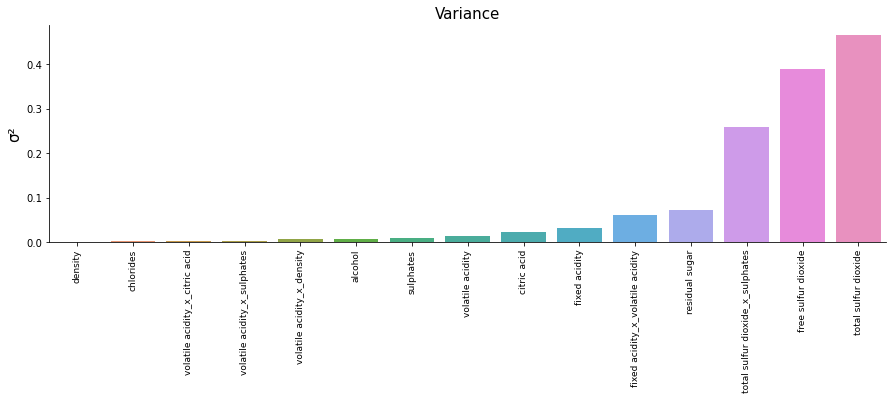

In [53]:
#create table for variance
var_df = pd.DataFrame(X.var().sort_values(), columns = ['var'])

#set figure params
plt.figure(figsize=(15,4))

#plt figure
ax = sns.barplot(x = var_df.index, y = 'var', data = var_df)
ax.set_xticklabels(var_df.index, rotation=90, size =9)
ax.set_ylabel('σ²', size = 15)
ax.set_title('Variance', size = 15)
sns.despine()
plt.show()

The bar chart shows the majority of variables to have low variance, with the 10 variables from `density` to `fixed acidity_x_volatile acidity`  having σ² of under 0.1. Sizeable variance can be seen in `total sulfur dioxide_x_suplates`, `free_sulfur dioxide`, `total sulfur_dioxide`, with σ² values  of 0.25, 0.35 and 0.42 respectively. All variables have non-zero variance, so none will be dropped at this stage.

### 4.2 Assessing pairwise correlations (multicollinearity)

Multicollinearity refers to a situation in which more than two explanatory variables in a multiple regression model are highly linearly related with a correlation ~1. Variables with matching distributions are redundant in regression models, so these can be dropped to increase model power. We can assess multicollinearity across variables in our scaled data using seaborn's heatmap function and its associated Pearson correlation scores:

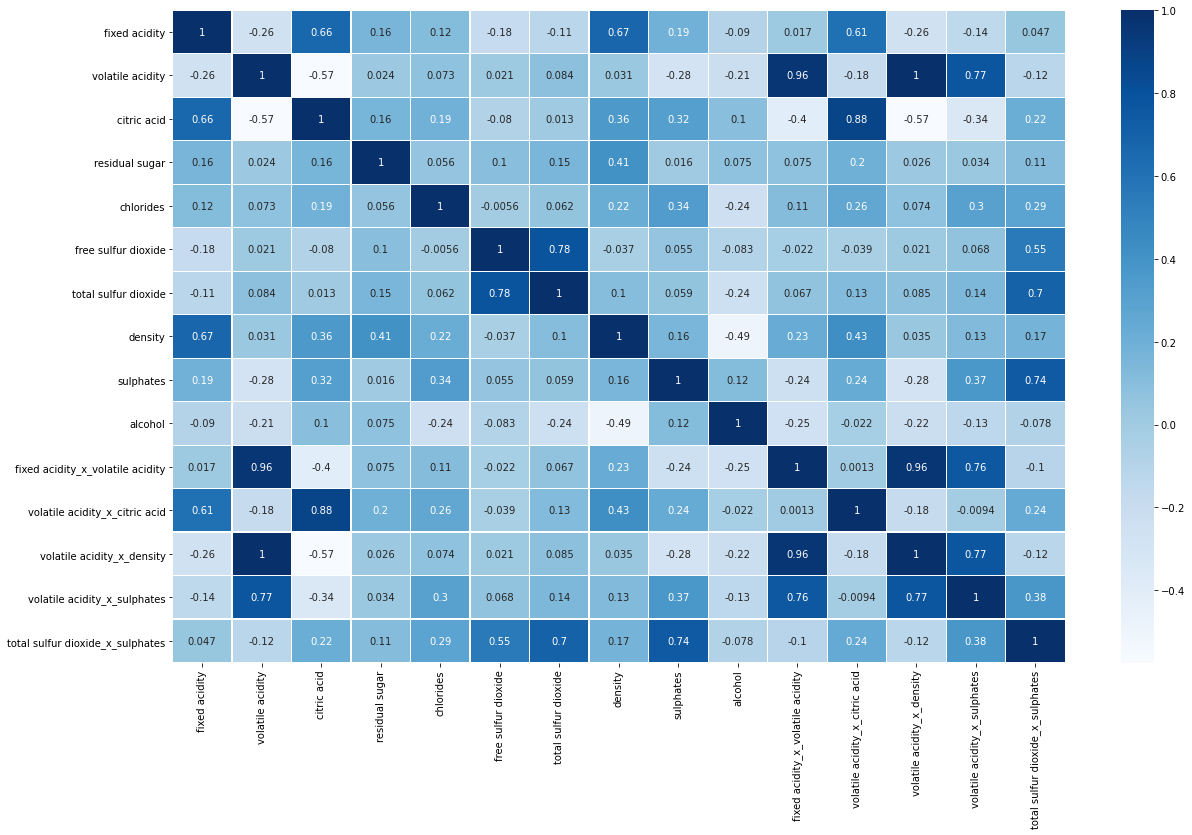

In [54]:
#view correlation between scaled variabels
plt.figure(figsize=(20,12))
sns.heatmap(X.corr(), linewidth=0.2, cmap="Blues", annot=True)
plt.show()

The pairplot shows correlations between variables in our dataset. The two variables `volatile acidity` and `volatile acidity_x_suplhates` are collinear, with a pariwise correaltion score of 1. There are strong correlations betweeen `volatile acidity_x_density` + `fixed acidity_x_volatile acidity` and `fixed acidity_x_volatile acidity` + `volatile_acidity` producing pairwise correlation scores of over 0.95.

### 4.3 Sequential feature selection

Sequential feature selection algorithms are a family of greedy search algorithms that are used to reduce an initial d-dimensional feature space to a k-dimensional feature subspace where k < d. We will use the backward feature selection method. This approach operates by sequentially removing features and evaluating model performance at each step. More details on sequential feature selection algorithms can be found [here](http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/). Let's run our backward feature selection algorithm:

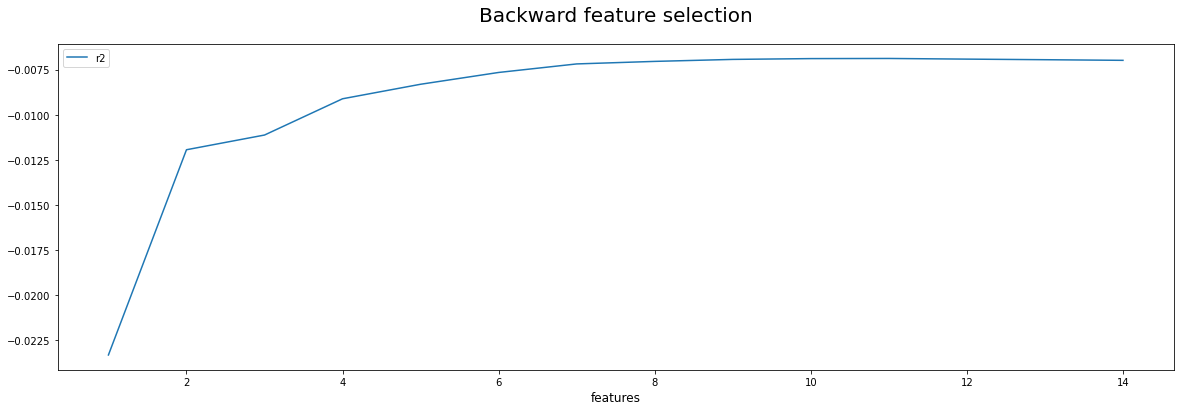

In [55]:
#import sequential feature selector
from mlxtend.feature_selection import SequentialFeatureSelector

#specify cv_fold
from sklearn.model_selection import StratifiedKFold
cv_fold_q = StratifiedKFold(n_splits=10, shuffle = True, random_state = 42) #faster function for testing

#assign variables
k  = np.arange(1,len(X.columns)).tolist()
model = LinearRegression()
score = 'neg_mean_squared_error'
b_cv_score = []
b_selected_features = []

#start loop
for value in k:
    
#create the SequentialFeatureSelector object, and configure the parameters.
    bsfs = SequentialFeatureSelector(model, 
               k_features=value,
               forward=False, 
               floating=False,
               scoring=score,
               n_jobs = -1,
               verbose = 0
               )

#fit the object to the training data and append scores
    bsfs = bsfs.fit(X, y)
    b_cv_score.append(bsfs.k_score_)
    b_selected_features.append(X.columns[list(bsfs.k_feature_idx_)])


#plot figure
ax = pd.DataFrame(b_cv_score,k,['r2']).plot.line(figsize = (20,6))
ax.set_xlabel('features', fontsize = 12)
plt.title('Backward feature selection', fontsize = 20, y = 1.05, x = 0.5)
plt.show()

The line chart above shows model performance across subsets of our dataset. Subset performance improves as the number of features increases from 1 - 8. The nMSE value begins to plateau from subsets of size 8 until the maximum of 14 features.
Let's look at the features in the best performing subset:

In [56]:
bsfs_df = pd.DataFrame([b_cv_score, b_selected_features]).T
bsfs_df = bsfs_df.reset_index()
bsfs_df.columns = ['no', 'score', 'features']
bsfs_features = bsfs_df.sort_values(by = 'score', ascending = False)['features'].tolist()[0]
print("Best performing subset: ", bsfs_features.tolist())

Best performing subset:  ['fixed acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'density', 'alcohol', 'fixed acidity_x_volatile acidity', 'volatile acidity_x_citric acid', 'volatile acidity_x_density', 'total sulfur dioxide_x_sulphates']


The optimal subset contains 11 of the 14 original features. This subset also contains only one of our colinear features `volatile acidity_x_suplhates` identified in the pairplot analysis, so no further features will need to be removed.

## 4. Regression Analysis

### 4.1 Test / train split

Now we've identified the best subset, we need to processed data into test and training sets. We will use a test/train split of 85% and 15% respectively:

In [57]:
#import module
from sklearn.model_selection import train_test_split

X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
#y = scaler.fit_transform(np.array(y).reshape(-1, 1))
y = df.pH

#split data into test/train groups
X_train, X_test, y_train, y_test = train_test_split(X[bsfs_features], y, test_size=0.15, random_state=42) #EFS features

#show dataset shapes
print("X train shape is: ", X_train.shape)
print("Y train shape is: ", y_train.shape)
print("X test  shape is: ", X_test.shape)
print("y test  shape is: ", y_test.shape)

X train shape is:  (1359, 11)
Y train shape is:  (1359,)
X test  shape is:  (240, 11)
y test  shape is:  (240,)


### 4.2 Hyperparamter tuning and model selection

Sklearn comes with numerous supervised [regression models](https://scikit-learn.org/stable/supervised_learning.html). For our project we will assess the performance of a series of linear models, using r2, Root Mean Squared Error (rMSE), and Cross-Validation (cv) scores:

In [ ]:
#import pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import numpy as np

#import regression models for continuous data
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LassoLars
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import cross_val_score

#construct some pipelines
pipe_lr = LinearRegression() #N/A
pipe_ridge = Ridge() #alpha_range
pipe_lasso =  Lasso(max_iter = 1000000) #alpha_range
pipe_elastic = ElasticNet(max_iter = 10000000)
pipe_lassolars = LassoLars()#alpha_range
pipe_omp = OrthogonalMatchingPursuit() #n_nonzero_coefs_range
pipe_bayridge = BayesianRidge() #alpha_range
pipe_theil = TheilSenRegressor() #max_subpop_range
pipe_huber = HuberRegressor(max_iter = 1000000) #alpha_range


#arrange some params
normalize_range = [True, False]
alpha_range = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10, 20, 100]
n_nonzero_coefs_range = np.arange(1, len(X_train.columns)+1)
bay_range = [1e-6, 1e-5, 1e-4, 1e-3]
max_subpop_range = [1, 5, 10, 50, 100, 500, 1000]
n_subsamples_range = np.arange(13, 80, 5)


#set grid params
grid_params_lr = [{'normalize':normalize_range}]
grid_params_ridge = [{'alpha':alpha_range}]
grid_params_lasso = [{'alpha':alpha_range}]
grid_params_elastic = [{'alpha': alpha_range}]
grid_params_lassolars = [{'alpha':alpha_range}]
grid_params_omp = [{'n_nonzero_coefs':n_nonzero_coefs_range}]
grid_params_bayridge = [{'alpha_1': bay_range , 'alpha_2': bay_range, 'lambda_1': bay_range, 'lambda_2': bay_range}]
grid_params_theil = [{'n_subsamples': n_subsamples_range}]
grid_params_huber = [{'alpha':alpha_range}]

#construct grid searches
jobs = -1

gs_lr = GridSearchCV(estimator=pipe_lr,
                    param_grid=grid_params_lr,
                    scoring='neg_mean_squared_error',
                    cv = 4) 

gs_ridge = GridSearchCV(estimator=pipe_ridge,
                    param_grid=grid_params_ridge,
                    scoring='neg_mean_squared_error',
                    cv = 4)

gs_lasso = GridSearchCV(estimator=pipe_lasso,
                    param_grid=grid_params_lasso,
                    scoring= 'neg_mean_squared_error',
                    cv=4)

gs_elastic = GridSearchCV(estimator=pipe_elastic,
                    param_grid=grid_params_elastic,
                    scoring= 'neg_mean_squared_error',
                    cv=4) 

gs_lassolars = GridSearchCV(estimator=pipe_lassolars,
                    param_grid=grid_params_lassolars,
                    scoring= 'neg_mean_squared_error',
                    cv=4) 

gs_omp = GridSearchCV(estimator=pipe_omp,
                    param_grid=grid_params_omp,
                    scoring= 'neg_mean_squared_error',
                    cv=4) 

gs_bayridge = GridSearchCV(estimator=pipe_bayridge,
                    param_grid=grid_params_bayridge,
                    scoring= 'neg_mean_squared_error',
                    cv=4) 

gs_theil = GridSearchCV(estimator=pipe_theil,
                    param_grid=grid_params_theil,
                    scoring= 'neg_mean_squared_error',
                    cv=4) 

gs_huber  = GridSearchCV(estimator=pipe_huber,
                    param_grid=grid_params_huber,
                    scoring= 'neg_mean_squared_error',
                    cv=4) 

#list of pipelines for ease of iteration
grids = [gs_lr, gs_ridge, gs_lasso, gs_elastic, gs_lassolars, gs_omp, gs_bayridge, gs_theil, gs_huber]


# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'OLS', 1: 'Ridge', 2:'Lasso',3:'ElasticNet', 4:'LassoLars', 5:'OrthogonalMatchingPursuit', 6:'Bayesian Ridge', 7:'TheilSen',8:'Huber'}

print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    # Fit grid search
    gs.fit(X_train, y_train)
    # Best params
    print('Best params: %s' % gs.best_params_)
    # Best training data accuracy
    print('Best training neg_mean_squared_error: %.5f' % gs.best_score_)
    # Predict on test data with best params
    y_pred = gs.predict(X_test)
    # Test data accuracy of model with best params
    print('Test set CV score for best params: %.5f ' % cross_val_score(gs, X_test, y_test, cv = 4).mean())
    # Track best (highest test accuracy) model   
    if cross_val_score(gs, X_test, y_test, cv = 4).mean() > best_acc:
        best_acc = cross_val_score(gs, X_test, y_test, cv = 4).mean()
        best_gs = gs
        best_clf = idx
print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])

Performing model optimizations...

Estimator: OLS
Best params: {'normalize': False}
Best training neg_mean_squared_error: -0.00647
Test set CV score for best params: -0.00595 

Estimator: Ridge
Best params: {'alpha': 0.001}
Best training neg_mean_squared_error: -0.00647
Test set CV score for best params: -0.00598 

Estimator: Lasso
Best params: {'alpha': 1e-08}
Best training neg_mean_squared_error: -0.00647
Test set CV score for best params: -0.00595 

Estimator: ElasticNet
Best params: {'alpha': 1e-08}
Best training neg_mean_squared_error: -0.00647


All models had similar nMSE scores across the training and test datasets. OLS (linear regression), Lasso, ElasticNet, LassoLars, and OrthogonalMatchingPursuit were marginally better than other models, sharing cross-validated test performance scores of -0.00595. TheilSen and Huber algorithms had the worst training scores of -0.00649. Whereas, Bayesian Ridge had the worst test cv score of -0.00623. As there are several models in the top-performing tier, I will need to select one to evaluate further. I have chosen to proceed using the OLS algorithm, as it is the model which was automatically saved from the hyperparameter tuning and model selection above.

## 5. Model Evaluation

Now we have identified our candidate model, we need to make sure it meets the assumptions of regression modeling: normality, linearity, homoscedasticity, and absence of multicollinearity. Let's build our best performing model:

In [ ]:
#build highest performing regression model 
y_pred = best_gs.predict(X_test)
residuals = y_pred - y_test

### 5.1 Residual normality

Normality is the assumption that the underlying residuals (predictive error) are normally distributed, or approximately so. The null hypothesis states that the residuals are normally distributed, against the alternative hypothesis that they are not normally distributed. Let's check the distribution of our residuals:

In [ ]:
#check distribution of residuals
ax = sns.histplot(residuals)
plt.figure(figsize=(15,6))
ax.set_ylabel('residuals')
ax.set_xlabel('')
plt.show()

From the histogram we can see the residuals follow a normal distribution centred around zero.

### 5.2 Homoscedasticity & linearity

Homoscedasticity refers to whether these residuals are equally distributed. Data is homoscedastic if it looks somewhat like a shotgun blast of randomly distributed data. The opposite of homoscedasticity is heteroscedasticity, where you might find a cone or fan shape in your data. Heteroscedasticity indicates predictive bias in linear regression models and is usually associated with poor model generalizability.

Linearity means that the predictor variables in the regression have a straight-line relationship with the outcome variable. If the observed and predicted values have a linear relationship, it implies that the implemented linear regression model is appropriate for the regression task. If the observed vs predicted plot shows a non-linear relationship, other algorithms which support non-linear relationships (such as a random forest) would be better suited.

Let's create regplots using seaborn to assess homoscedasticity and linearity:

In [ ]:
#set plot area
f, axes = plt.subplots(1, 2)
f.set_size_inches(15, 4)

#make homoscedasticity plot
sns.regplot(x = y_pred, y = residuals, ax=axes[0])
axes[0].set_title('Residuals vs Predicted')

#make linearity plot
sns.regplot(x = y_pred, y = y_test, ax=axes[1])
axes[1].set_title('Observed vs Predicted')

#show plots
plt.show()

The Residuals vs Predicted regplot shows an equal distribution of variables, suggesting the data is homoscedastic. Similarly, the observed vs predicted plot shows a linear relationship, inferring data linearity. The multicollinearity assumption was met during our analysis in feature selection (*see heatmap in section 4.2*).

## 6. Concluding remarks

Overall, we successfully created a regression model to predict wine pH using the 'Wine Quality' dataset. The model has low value given the already established cheap and effective methods for predicting wine pH. However, the 'Wine Quality' dataset only contains Vina Verde wines, so further testing on a variety of wine types would be necessary to ensure generalizability before the model could be used to predict pH for non-specific wine types.